#**H&M data**

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 14.3 MB/s 
     |████████████████████████████████| 181 kB 54.1 MB/s 
     |████████████████████████████████| 147 kB 52.3 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b3376da1fe9937a500dda9d2bbfd8ccc0425297e399125a215a63cf302c66c6d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Notebook Color Scheme:


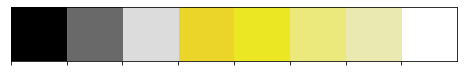

In [3]:
# Libraries
import os
import gc
import wandb
import time
import random
import math
import glob
from scipy import spatial
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
from numpy import dot, sqrt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from IPython.display import display_html
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'HandM', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[33m'
    E = '\033[0m'

my_colors = ["#000000", "#696969", "#DCDCDC", "#EBD529","#EBE823", "#EBE97C", "#EBE9B2", "#FFFFFF"]    
#my_colors = ["#AF0848", "#E90B60", "#CB2170", "#954E93", "#705D98", "#5573A8", "#398BBB", "#00BDE3"]
print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [4]:
customers = pd.read_csv('drive/MyDrive/Doutorado/Disciplinas/Visualização de Informação/Trabalho Final/data/customers.csv')
articles = pd.read_csv('drive/MyDrive/Doutorado/Disciplinas/Visualização de Informação/Trabalho Final/data/articles.csv')
transactions = pd.read_csv('drive/MyDrive/Doutorado/Disciplinas/Visualização de Informação/Trabalho Final/data/transactions_train.csv')
ss = pd.read_csv('drive/MyDrive/Doutorado/Disciplinas/Visualização de Informação/Trabalho Final/data/sample_submission.csv')

In [5]:
def adjust_id(x):
    '''Adjusts article ID code.'''
    x = str(x)
    if len(x) == 9:
        x = "0"+x
    
    return x


def insert_image(path, zoom, xybox, ax):
    '''Insert an image within matplotlib'''
    imagebox = OffsetImage(mpimg.imread(path), zoom=zoom)
    ab = AnnotationBbox(imagebox, xy=(0.5, 0.7), frameon=False, pad=1, xybox=xybox)
    ax.add_artist(ab)
    
    
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


# === 🐝 W&B ===
def save_dataset_artifact(run_name, artifact_name, path):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='HandM', 
                     name=run_name, 
                     config=CONFIG)
    artifact = wandb.Artifact(name=artifact_name, 
                              type='dataset')
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})
    

In [6]:
def similar_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    '''Creates a custom function for the color of the wordcloud.'''
    
    h = 270 # 0 - 360 <- the color hue
    s = 40 # 0-100 <- the color saturation
    l = random_state.randint(30, 70) # 0 - 100 <- gradient
    
    return "hsl({}, {}%, {}%)".format(h, s, l)

In [7]:
print(clr.S+"ARTICLES:"+clr.E, articles.shape)
display_html(articles.head(3))
print("\n", clr.S+"CUSTOMERS:"+clr.E, customers.shape)
display_html(customers.head(3))
print("\n", clr.S+"TRANSACTIONS:"+clr.E, transactions.shape)
display_html(transactions.head(3))
print("\n", clr.S+"SAMPLE_SUBMISSION:"+clr.E, ss.shape)
display_html(ss.head(3))

ARTICLES: (105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.



 CUSTOMERS: (1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...



 TRANSACTIONS: (31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2



 SAMPLE_SUBMISSION: (1371980, 2)


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...


## Preprocessing

In [8]:
# 🐝 W&B Experiment
run = wandb.init(project='HandM', name='Articles', config=CONFIG)

<IPython.core.display.Javascript object>

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


In [9]:
print(clr.S+"There are no missing values in any columns but 'Detail Description':"+clr.E,
      articles.isna().sum()[-1], "total missing values")

# Replace missing values
articles.fillna(value="No Description", inplace=True)

# Adjust the article ID and product code to be string & add "0"
articles["article_id"] = articles["article_id"].apply(lambda x: adjust_id(x))
articles["product_code"] = articles["article_id"].apply(lambda x: x[:3])

There are no missing values in any columns but 'Detail Description': 416 total missing values


In [10]:
# Get all paths from the image folder
all_image_paths = glob.glob(f"../input/h-and-m-personalized-fashion-recommendations/images/*/*")

print(clr.S+"Number of unique article_ids within articles.csv:"+clr.E, len(articles), "\n"+
      clr.S+"Number of unique images within the image folder:"+clr.E, len(all_image_paths), "\n"+
      clr.S+"=> not all article_ids have a corresponding image!!!"+clr.E, "\n")

# 🐝 Log Distinct article IDs
wandb.log({"article_ids":len(articles)})

# Get all valid article ids
# Create a set() - as it moves faster than a list
all_image_ids = set()

for path in tqdm(all_image_paths):
    article_id = path.split('/')[-1].split('.')[0]
    all_image_ids.add(article_id)

Number of unique article_ids within articles.csv: 105542 
Number of unique images within the image folder: 0 
=> not all article_ids have a corresponding image!!! 



0it [00:00, ?it/s]


Total Number of unique Product Names: 45875


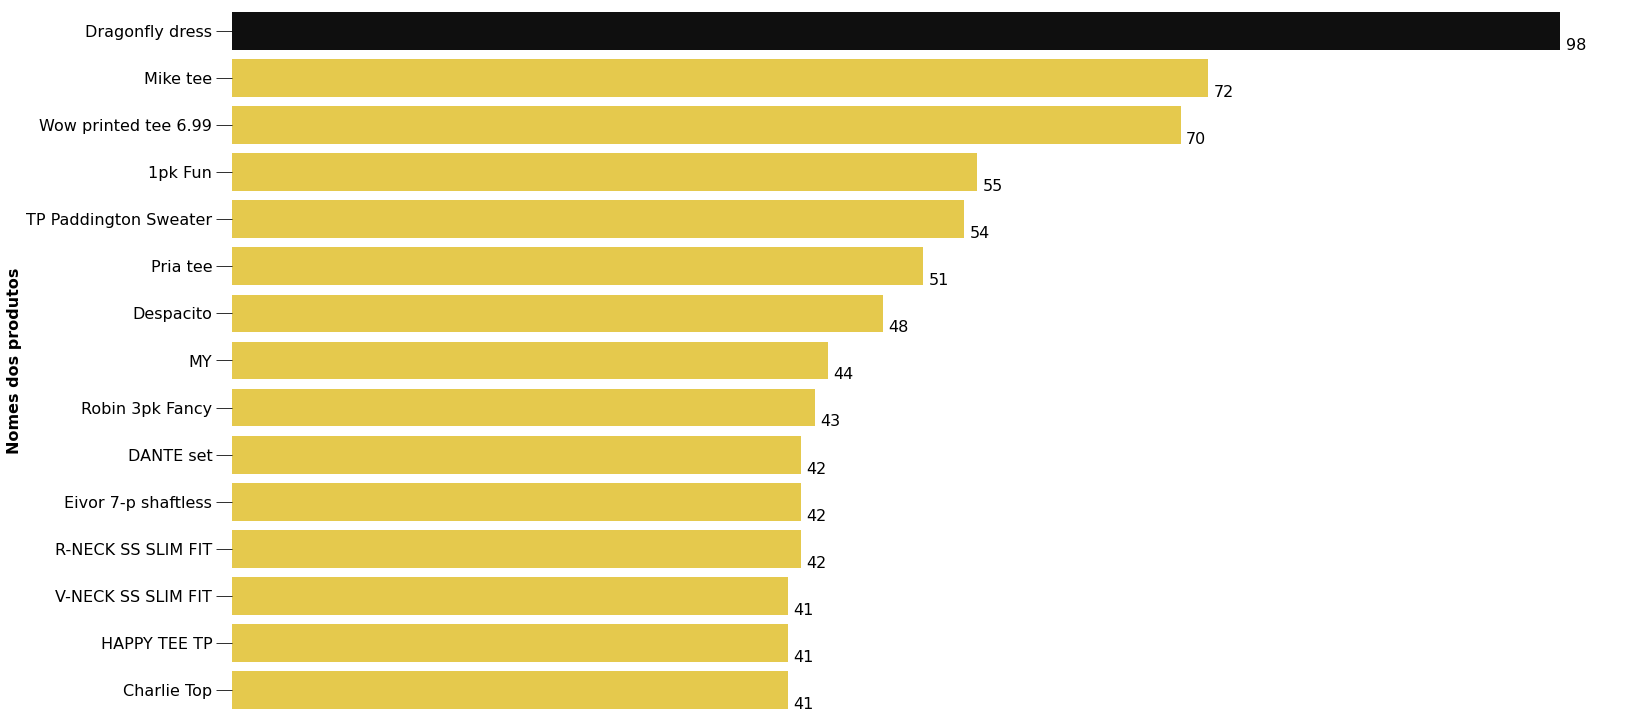

<Figure size 432x288 with 0 Axes>

In [11]:
print(clr.S+"Total Number of unique Product Names:"+clr.E, articles["prod_name"].nunique())

# Data
prod_name = articles["prod_name"].value_counts().reset_index().head(15)
total_prod_names = articles["prod_name"].nunique()
clrs = ["#0f0f0f" if x==max(prod_name["prod_name"]) else '#fed934' for x in prod_name["prod_name"]]

# Get images

prod_name_images = articles[articles["prod_name"].isin(prod_name["index"].tolist())]
image_names = prod_name_images["prod_name"].tolist()

# Plot
fig, ax = plt.subplots(figsize=(25, 13))
# plt.title('Nomes mais frequentes dos produtos', size=22, weight="bold")

sns.barplot(data=prod_name, x="prod_name", y="index", ax=ax,
            palette=clrs)

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Nomes dos produtos", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

# insert_image(path='../input/hm-fashion-recommender-dataset/pics/dragonfly.jpg', zoom=0.45, xybox=(92, 11), ax=ax)

sns.despine(left=True, bottom=True)
plt.show();

print("\n")

plt.tight_layout()
plt.show()


Total Number of unique Product Types: 131


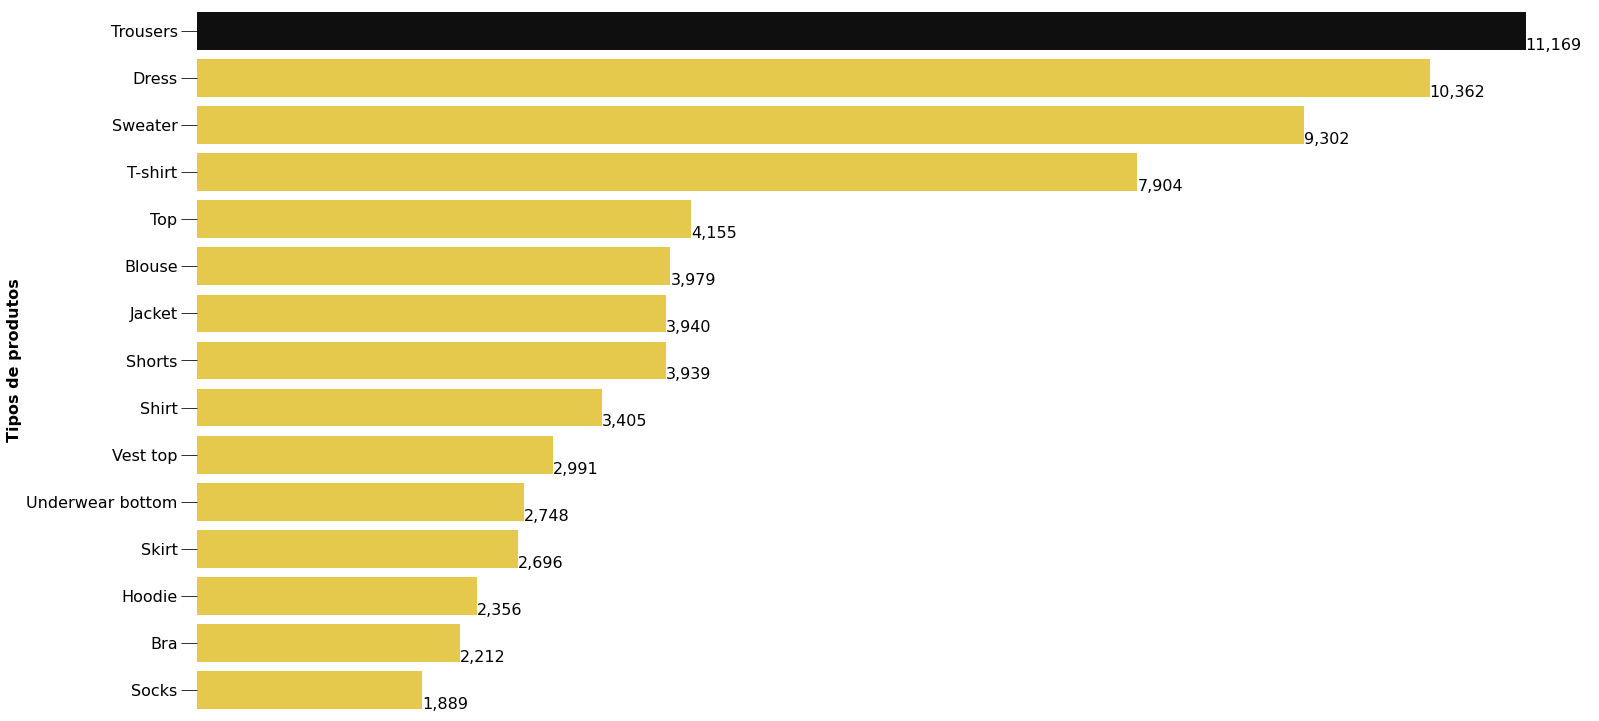

<Figure size 432x288 with 0 Axes>

In [12]:

print(clr.S+"Total Number of unique Product Types:"+clr.E, articles["product_type_name"].nunique())

# Data
prod_type = articles["product_type_name"].value_counts().reset_index().head(15)
total_prod_types = articles["product_type_name"].nunique()
clrs = ["#0f0f0f" if x==max(prod_type["product_type_name"]) else '#fed934' for x in prod_type["product_type_name"]]

# Get images
prod_type_images = articles[articles["product_type_name"].isin(prod_type["index"].tolist())]#.groupby("product_type_name")["path"].first().reset_index()
# image_paths = prod_type_images["path"].tolist()
image_names = prod_type_images["product_type_name"].tolist()

# Plot
fig, ax = plt.subplots(figsize=(25, 13))
# plt.title('Tipos mais frequentes de produtos', size=22, weight="bold")

sns.barplot(data=prod_type, x="product_type_name", y="index", ax=ax,
            palette=clrs)

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Tipos de produtos", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)


sns.despine(left=True, bottom=True)
plt.show();

print("\n")

plt.tight_layout()
plt.show()

Total Number of unique Product Group: 19


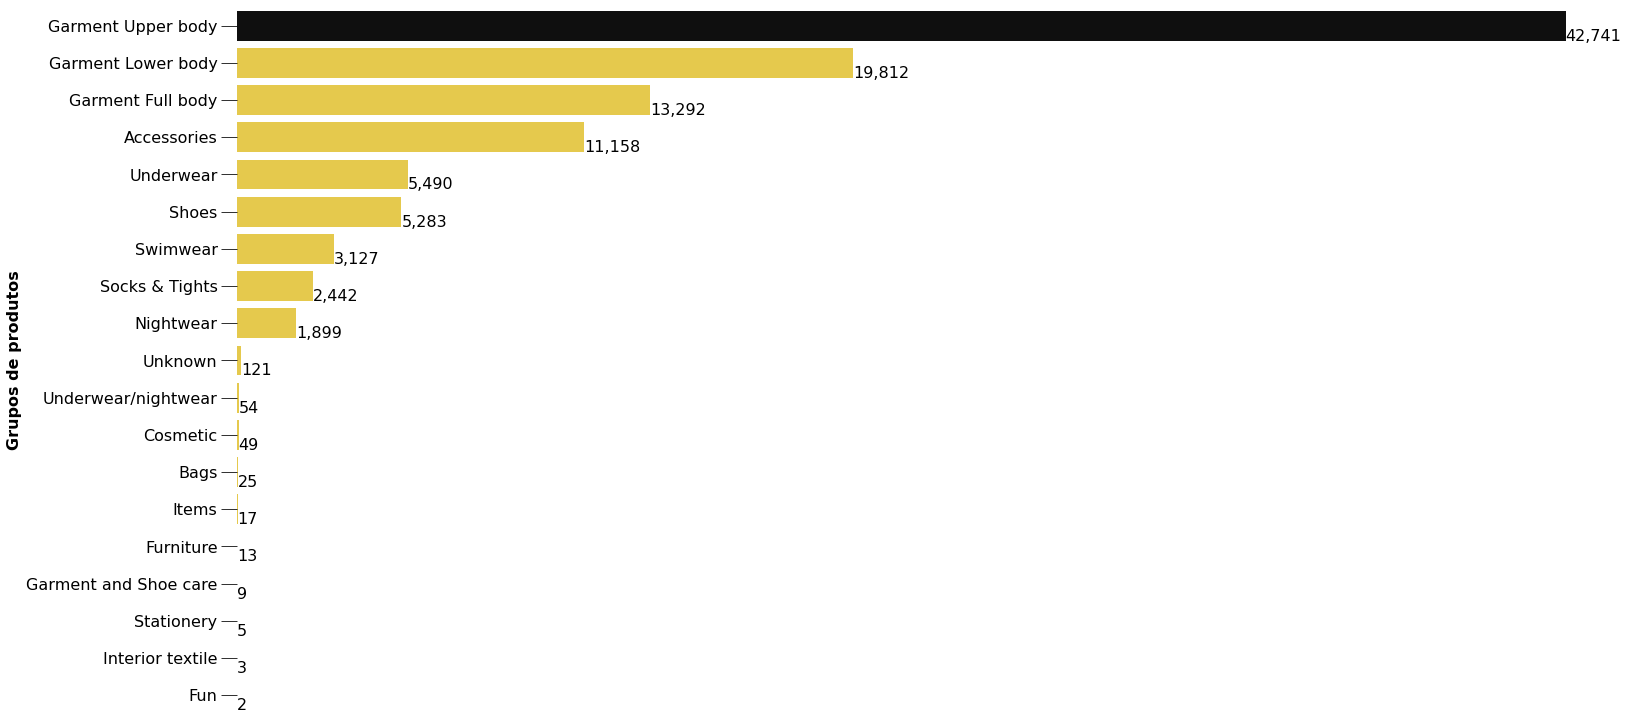

In [13]:
print(clr.S+"Total Number of unique Product Group:"+clr.E, articles["product_group_name"].nunique())

# Data
prod_group = articles["product_group_name"].value_counts().reset_index()
total_prod_groups = articles["product_group_name"].nunique()
clrs = ["#0f0f0f" if x==max(prod_group["product_group_name"]) else '#fed934' for x in prod_group["product_group_name"]]

# Get images
prod_group_images = articles[articles["product_group_name"].isin(prod_group["index"].tolist())]
image_names = prod_group_images["product_group_name"].tolist()

# Plot
fig, ax = plt.subplots(figsize=(25, 13))
#plt.title('Grupos mais frequentes de produtos', size=22, weight="bold")

sns.barplot(data=prod_group, x="product_group_name", y="index", ax=ax,
            palette=clrs)

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Grupos de produtos", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

sns.despine(left=True, bottom=True)
plt.show();

In [14]:
# 🐝 Log Barplot to W&B
create_wandb_plot(x_data=prod_group["index"], y_data=prod_group["product_group_name"],
                  x_name="Product Group", y_name="Frequency", 
                  title="- Most Frequent Product Group -", log="prod_group", plot="bar")

In [15]:
def change_color(x):
    '''Change color name.'''
    if ("light" in x.lower().strip()) or \
        ("dark" in x.lower().strip()) or \
        ("greyish" in x.lower().strip()) or \
        ("yellowish" in x.lower().strip()) or \
        ("greenish" in x.lower().strip()) or \
        ("off" in x.lower().strip()) or \
        ("other" in x.lower().strip()):
        x = x.split(" ")[-1]
        
    return x

articles["colour_group_name"] = articles["colour_group_name"].apply(lambda x: change_color(x))

Total Number of unique Product Appearances: 30
Total Number of unique Product Colors (after preprocess): 20


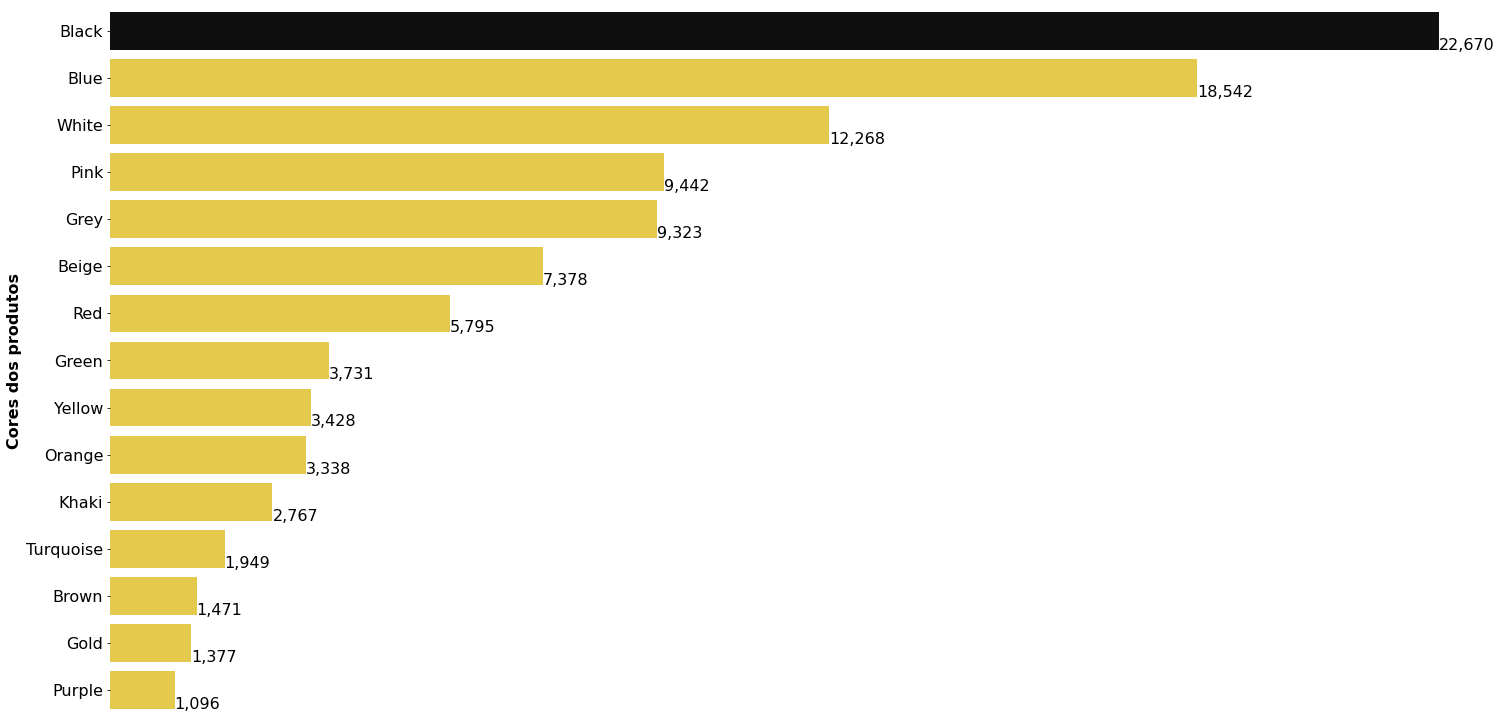

In [16]:
# Appearance and color
print(clr.S+"Total Number of unique Product Appearances:"+clr.E, articles["graphical_appearance_name"].nunique())
print(clr.S+"Total Number of unique Product Colors (after preprocess):"+clr.E, articles["colour_group_name"].nunique())

# --- Data 1 ---
prod_appearance = articles["graphical_appearance_name"].value_counts().reset_index().head(15)
total_prod_appearances = articles["graphical_appearance_name"].nunique()
clrs1 = ["#0f0f0f" if x==max(prod_appearance["graphical_appearance_name"]) else '#fed934' for x in prod_appearance["graphical_appearance_name"]]


# Get images
prod_appearance_images = articles[articles["graphical_appearance_name"].isin(prod_appearance["index"].tolist())]
image_names1 = prod_appearance_images["graphical_appearance_name"].tolist()

# --- Data 2 ---
prod_color = articles["colour_group_name"].value_counts().reset_index().head(15)
total_prod_color = articles["colour_group_name"].nunique()
clrs2 = ["#0f0f0f" if x==max(prod_color["colour_group_name"]) else '#fed934' for x in prod_color["colour_group_name"]]

# Get images
prod_color_images = articles[articles["colour_group_name"].isin(prod_color["index"].tolist())]
image_names2 = prod_color_images["colour_group_name"].tolist()

# Plot
fig, ax2 = plt.subplots(figsize=(25, 13))

# ax1.set_title('Aparições mais frequentes dos produtos', size=22, weight="bold")
# sns.barplot(data=prod_appearance, x="graphical_appearance_name", y="index", ax=ax1,
#             palette=clrs2)

# show_values_on_bars(axs=ax1, h_v="h", space=0.4)
# ax1.set_ylabel("Aparições dos produtos", size = 16, weight="bold")
# ax1.set_xlabel("")
# ax1.set_xticks([])

# ax2.set_title('Cores mais frequentes dos produtos', size=22, weight="bold")
sns.barplot(data=prod_color, x="colour_group_name", y="index", ax=ax2,
            palette=clrs2)

show_values_on_bars(axs=ax2, h_v="h", space=0.4)
ax2.set_ylabel("Cores dos produtos", size = 16, weight="bold")
ax2.set_xlabel("")
ax2.set_xticks([])

sns.despine(left=True, bottom=True)
plt.show();

##**Customers**

### Customers Profile

In [17]:
# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'HandM', '_wandb_kernel': 'aot'}

In [18]:
# 🐝 W&B Experiment
run = wandb.init(project='HandM', name='Customers', config=CONFIG)

In [19]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [20]:
def create_age_interval(x):
    if x <= 25:
        return [16, 25]
    elif x <= 35:
        return [26, 35]
    elif x <= 45:
        return [36, 45]
    elif x <= 55:
        return [46, 55]
    elif x <= 65:
        return [56, 65]
    else:
        return [66, 99]

In [21]:
print(clr.S+"Missing values within customers dataset:"+clr.E)
print(customers.isna().sum())

# 🐝 Log Distinct customer IDs
wandb.log({"customer_ids":len(customers)})

# Fill FN and Active - the only available value is "1"
customers["FN"].fillna(0, inplace=True)
customers["Active"].fillna(0, inplace=True)

# Set unknown the club member status & news frequency
customers["club_member_status"].fillna("Unknown", inplace=True)

customers["fashion_news_frequency"] = customers["fashion_news_frequency"].replace({"None":"None"})
customers["fashion_news_frequency"].fillna("Unknown", inplace=True)

# Set missing values in age with the median
customers["age"].fillna(customers["age"].median(), inplace=True)
customers["age_interval"] = customers["age"].apply(lambda x: create_age_interval(x))

Missing values within customers dataset:
customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64


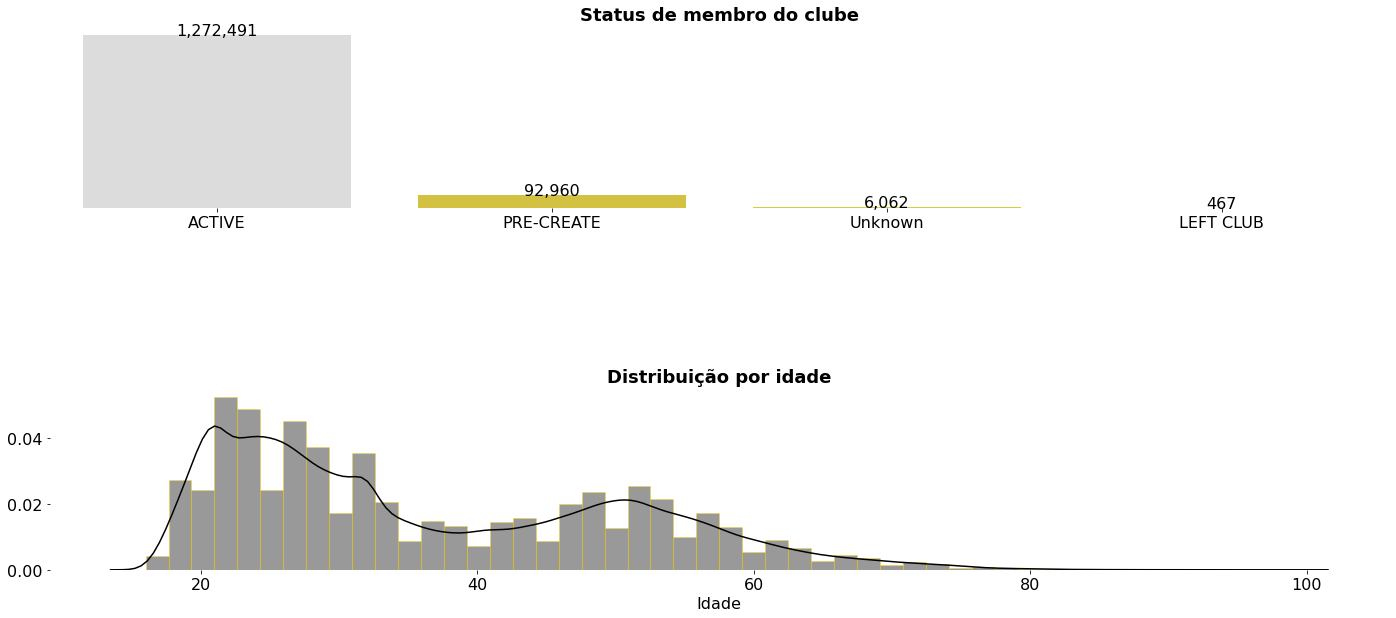

In [22]:
plt.figure(figsize=(24, 10))
#plt.suptitle('Perfil do Cliente', size=22, weight="bold")

ax1 = plt.subplot(2,1,1)
# ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

sns.countplot(data=customers, x="club_member_status", ax=ax1,
              order=customers['club_member_status'].value_counts().index,
              palette=my_colors[2:])
show_values_on_bars(axs=ax1, h_v="v", space=0.4)
ax1.set_title("Status de membro do clube", size=18, weight="bold")
ax1.set_yticks([])
ax1.set_xlabel("")
ax1.set_ylabel("")

# sns.countplot(data=customers, x="fashion_news_frequency", ax=ax2,
#               order=customers['fashion_news_frequency'].value_counts().index,
#               palette=my_colors[2:])
# show_values_on_bars(axs=ax2, h_v="v", space=0.4)
# ax2.set_title("Frequência das notícias da moda", size=18, weight="bold")
# ax2.set_yticks([])
# ax2.set_xlabel("")
# ax2.set_ylabel("")

sns.distplot(customers["age"], color="#000000", ax=ax3,
             hist_kws=dict(edgecolor="#FFD700"))
ax3.set_title("Distribuição por idade", size=18, weight="bold")
ax3.set_xlabel("Idade")
ax3.set_ylabel("")


sns.despine(left=True, bottom=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.99);

##**Transactions**

### Products that sell the most (in UNITS)

In [23]:
# 🐝 W&B Experiment
run = wandb.init(project='HandM', name='Transactions', config=CONFIG)

In [24]:
def adjust_id(x):
    '''Adjusts article ID code.'''
    x = str(x)
    if len(x) == 9:
        x = "0"+x
    
    return x

In [25]:
print(clr.S+"Missing values within transactions dataset:"+clr.E)
print(transactions.isna().sum())

# 🐝 Log length of transactions
wandb.log({"transaction_ids":len(transactions)})

# Adjust article_id (as did for articles dataframe)
transactions["article_id"] = transactions["article_id"].apply(lambda x: adjust_id(x))

Missing values within transactions dataset:
t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64


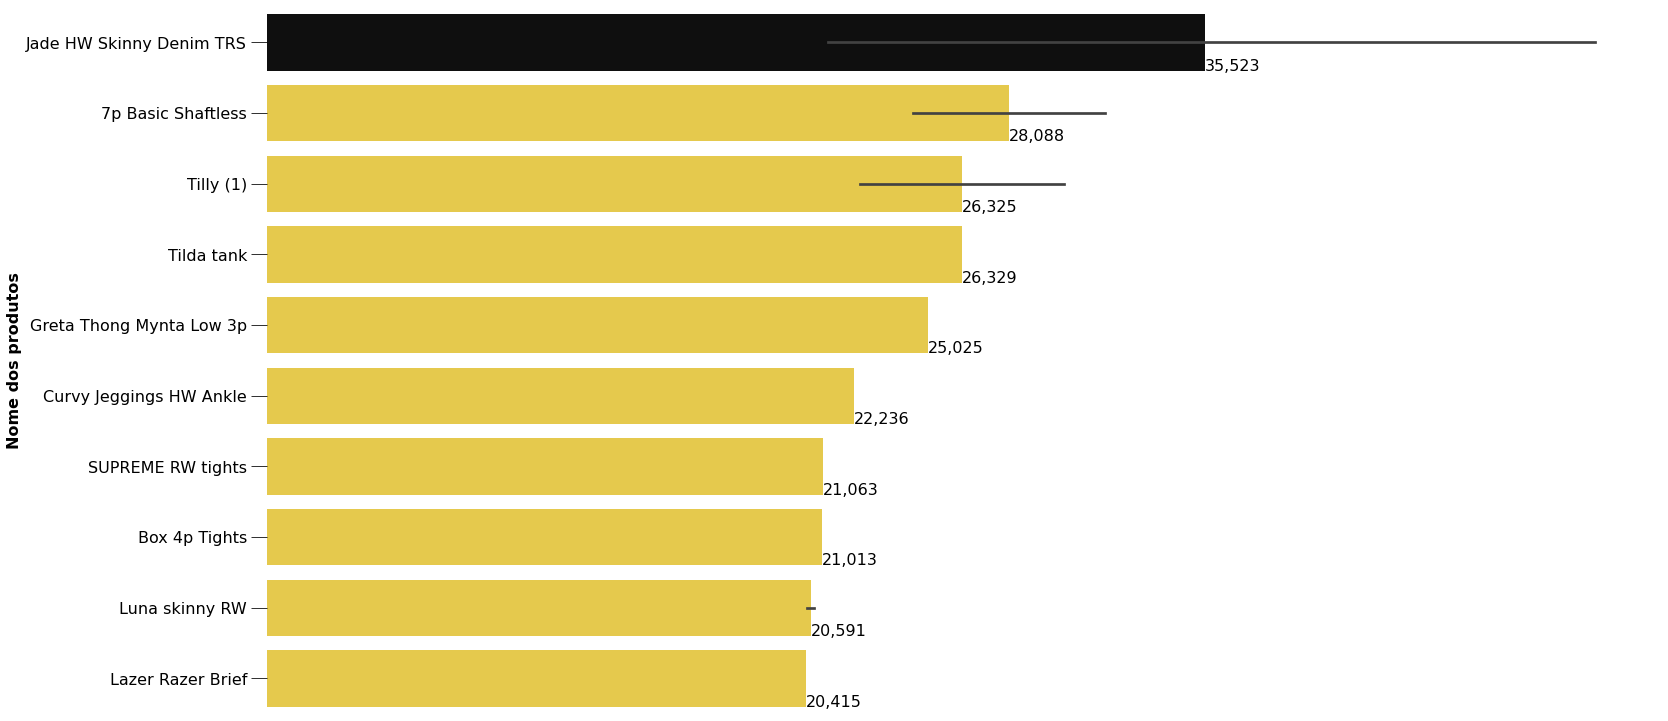

In [26]:
# Get data
top_sold_products = transactions["article_id"].value_counts().reset_index().head(15)
top_sold_products.columns = ["article_id", "count"]
top_sold_products = pd.merge(top_sold_products, articles, on="article_id")[["article_id", "count", "prod_name"]]

clrs = ["#0f0f0f" if x==max(top_sold_products["count"]) else "#fed934" for x in top_sold_products["count"]]

# Plot
fig, ax = plt.subplots(figsize=(25, 13))
# plt.title('Produtos mais vendidos (em unidades)', size=22, weight="bold")

sns.barplot(data=top_sold_products, x="count", y="prod_name", ax=ax,
            palette=clrs)

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Nome dos produtos", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

sns.despine(left=True, bottom=True)
plt.show();

print("\n")

### Order Attributes

=== UNITS/ORDER ===
Maximum Units/Order is: 1895 
Minimum Units/Order is: 1 
Average Units/Order is: 23.334630667241193 

=== SPENDING/ORDER ===
Maximum Spending/Order is: 57.67640677966092 
Minimum Spending/Order is: 0.0007627118644067 
Average Spending/Order is: 0.6493858271904589


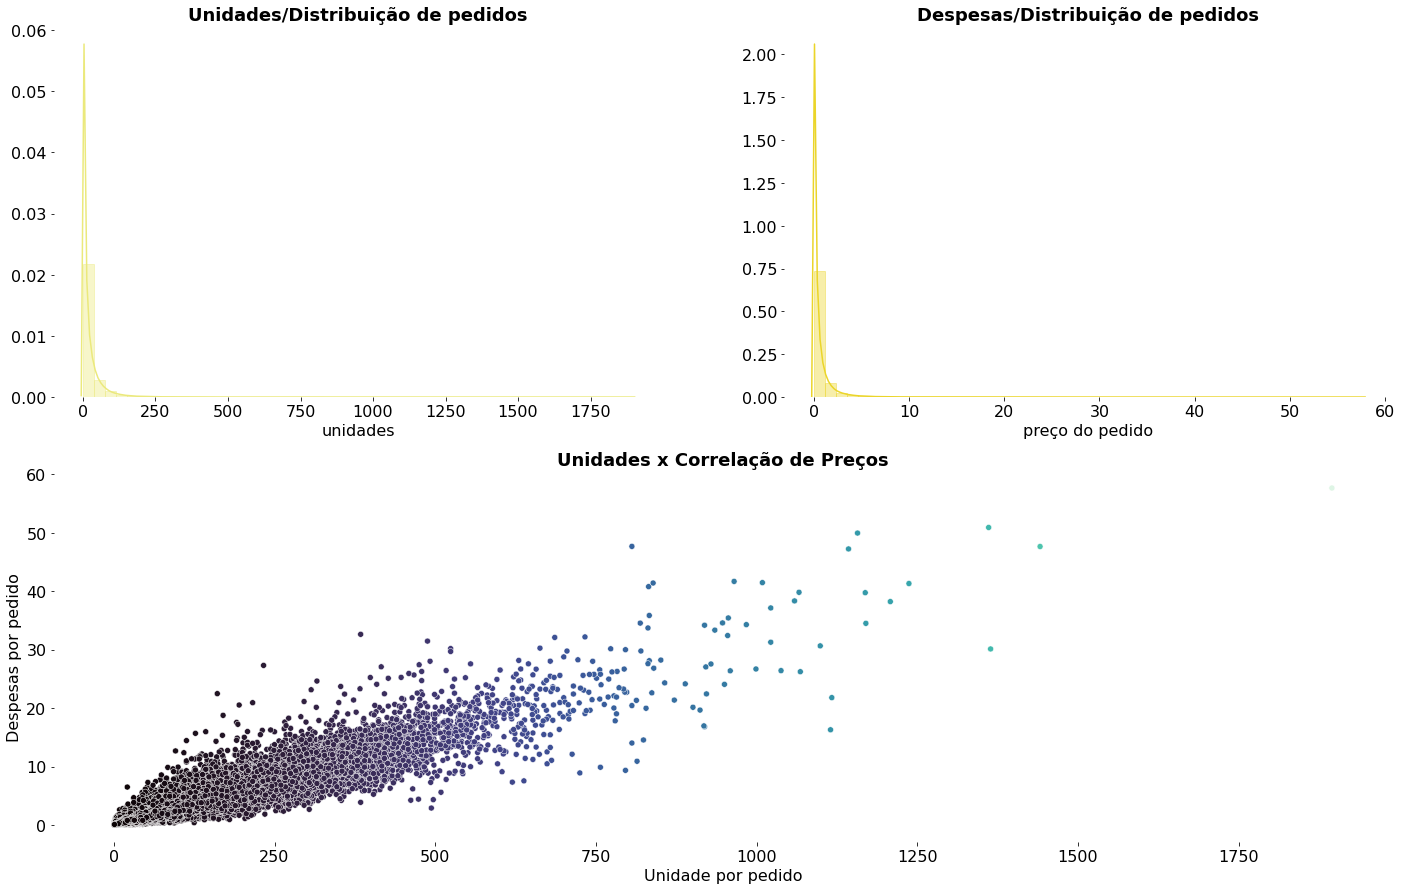

In [28]:
# Data
basket = transactions.groupby("customer_id").agg({'article_id':'count', 
                                                  'price': 'sum'}).reset_index()
basket.columns = ["customer_id", "units", "order_price"]

print(clr.S+"=== UNITS/ORDER ==="+clr.E)
print(clr.S+"Maximum Units/Order is:"+clr.E, basket["units"].max(), "\n" +
      clr.S+"Minimum Units/Order is:"+clr.E, basket["units"].min(), "\n" +
      clr.S+"Average Units/Order is:"+clr.E, basket["units"].mean(), "\n")

print(clr.S+"=== SPENDING/ORDER ==="+clr.E)
print(clr.S+"Maximum Spending/Order is:"+clr.E, basket["order_price"].max(), "\n" +
      clr.S+"Minimum Spending/Order is:"+clr.E, basket["order_price"].min(), "\n" +
      clr.S+"Average Spending/Order is:"+clr.E, basket["order_price"].mean())

# Plot
plt.figure(figsize=(24, 15))
#plt.suptitle('Atributos do pedido', size=22, weight="bold")

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

sns.distplot(basket["units"], color=my_colors[-3], ax=ax1,
             hist_kws=dict(edgecolor=my_colors[-3]))
ax1.set_title("Unidades/Distribuição de pedidos", size=18, weight="bold")
ax1.set_xlabel("unidades")
ax1.set_ylabel("")

sns.distplot(basket["order_price"], color=my_colors[-5], ax=ax2,
             hist_kws=dict(edgecolor=my_colors[-5]))
ax2.set_title("Despesas/Distribuição de pedidos", size=18, weight="bold")
ax2.set_xlabel("preço do pedido")
ax2.set_ylabel("")

sns.scatterplot(data=basket, x="units", y="order_price", hue="units", palette="mako", 
                legend=None, ax=ax3)
ax3.set_title("Unidades x Correlação de Preços", size=18, weight="bold")
ax3.set_ylabel("Despesas por pedido")
ax3.set_xlabel("Unidade por pedido")

sns.despine(left=True, bottom=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None);